In [1]:
import numpy as np
import scipy
import scipy.spatial
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import speechpy
from pydub import AudioSegment
from matplotlib.patches import ConnectionPatch
%matplotlib inline

In [2]:
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = None

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_19245/868284962.py:11: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['image.interpolation'] = None


In [3]:
def onsetDetect(signal, sr, hop_length, n_fft):
    onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
    onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length, n_fft=n_fft)
    trim_frames = []
    trim_frames.append(onset_frames_back[0]-1)
    trim_frames.append(onset_frames[-1]+2)
    trim_times = librosa.frames_to_time(trim_frames, sr=sr, hop_length=hop_length, n_fft = n_fft)
    return trim_frames, trim_times

def drawOnset(signal, trim_times, sr):
    librosa.display.waveshow(signal, sr=sr)
    plt.vlines(trim_times, min(signal), max(signal), color='r', alpha=0.8)

In [4]:
def trimSound(path, filename, trim_times):
    sound = AudioSegment.from_file(path+filename, format='mp3')
    trim = sound[trim_times[0]*1000:trim_times[1]*1000]
    return trim

def trimSave(trim, path, filename):
    trim.export(path + filename, format='mp3')

In [5]:
def getMFCC(signal, n_mfcc, sr, hop_length, n_fft):
    mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
    mfccs = mfccs[1:,]
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    return comprehensive_mfccs

def showMFCC(mfcc, sr, hop_length, n_fft):
    librosa.display.specshow(mfcc,
                        x_axis="time",
                        sr = sr,
                        hop_length = hop_length,
                        n_fft = n_fft)
    plt.colorbar(format="%+2.f")
    plt.show()

In [6]:
def amplitude_envelope(signal, n_fft, hop_length):
    return np.array([max(signal[i:i+n_fft]) for i in range(0, len(signal), hop_length)])

In [7]:
def pad(ae, target_len):
    return np.pad(ae, (0, target_len-ae.size))

In [8]:
def getMFCCNorm(mfcc):
    norm = speechpy.processing.cmvn(mfcc.T, variance_normalization=True)
    return norm.T

In [9]:
def DTW(ref_mfcc, comp_mfcc):
    D, wp = librosa.sequence.dtw(X=ref_mfcc, Y=comp_mfcc, metric='euclidean', backtrack=True)
    wp_s = np.asarray(wp) * hop_length / sr
    return D, wp, wp_s

In [10]:
def plotDTW(D, wp_s):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    librosa.display.specshow(D, x_axis='time', y_axis='time',
                             cmap='gray_r', hop_length=hop_length)
    ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
    plt.title('Warping Path on Acc. Cost Matrix $D$')
    plt.colorbar()

In [11]:
def plotAlign(sig1, sig2):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(12, 8))

    # Plot x_2
    librosa.display.waveshow(sig2, sr=sr, ax=ax2)
    ax2.set(title='comparison')

    # Plot x_1
    librosa.display.waveshow(sig1, sr=sr, ax=ax1)
    ax1.set(title='reference')
    ax1.label_outer()

    n_arrows = 20
    for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
        # Create a connection patch between the aligned time points
        # in each subplot
        con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                              axesA=ax1, axesB=ax2,
                              coordsA='data', coordsB='data',
                              color='r', linestyle='--',
                              alpha=0.5)
        ax2.add_artist(con)

In [12]:
def getDiff(ref_mfcc, comp_mfcc, wp):
    x = np.linspace(0, ref_mfcc.shape[1]-1, ref_mfcc.shape[1])
    re_wp = wp[::-1]
    y = [0] * ref_mfcc.shape[1]
    sig1 = 0
    for a, b in re_wp:
        val = max(0, (sum(np.abs(ref_mfcc[:,a]))-sum(np.abs(comp_mfcc[:,b])))/sum(np.abs(ref_mfcc[:,a])))
        if sig1 == a:
            y[a] = min(y[a],val)
        else:
            y[a] = min(1, val)
            sig1 = a
    return x, y, re_wp

In [13]:
def plotAll(x,y,ref_ae,comp_ae):
    if comp_ae.size < x.size:
        comp_ae = pad(comp_ae, x.size)
    plt.plot(x,y, label="MFCC_Diff", color="r", linestyle='--')
    plt.plot(x,ref_ae, label="ref", color = 'darkblue', )
    plt.plot(x,comp_ae, label="comp", color = 'skyblue',)
    plt.xlabel("frames")
    plt.legend()

In [21]:
t1 = 'naver_w_out.wav'
t2 = 'naver_w.wav'
t3 = 'oxford_m_out.wav'
t4 = 'oxford_m.wav'
t5 = 'oxford_w.wav'
t6 = 'oxford_m_nor.wav'
t7 = 'naver_w_nor.wav'

path_2 = './english_recordings/test_wav/'

In [22]:
y_t1, sr = librosa.load(path_2+t1)
y_t2, _ = librosa.load(path_2+t2)
y_t3, _ = librosa.load(path_2+t3)
y_t4, _ = librosa.load(path_2+t4)
y_t5, _ = librosa.load(path_2+t5)
y_t6, _ = librosa.load(path_2+t6)
y_t7, _ = librosa.load(path_2+t7)

In [48]:
ipd.Audio(y_t2, rate=sr)

In [49]:
ipd.Audio(y_t5, rate=sr)

In [16]:
hop_length = int(0.01 * sr)
n_fft = int(0.025 * sr)
print(hop_length, n_fft)

220 551


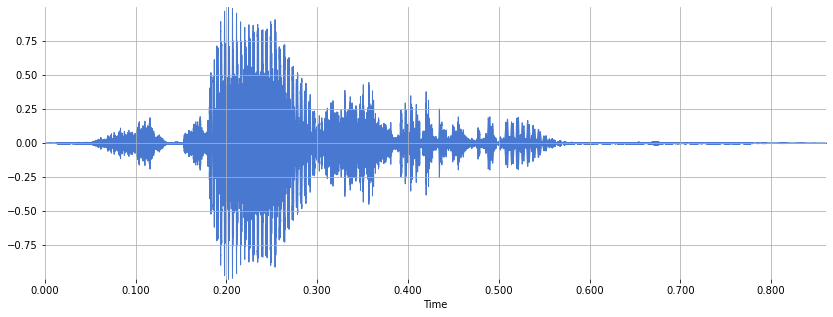

In [17]:
librosa.display.waveshow(y_t5, sr=sr)

In [18]:
ss = librosa.effects.preemphasis(y_t5)

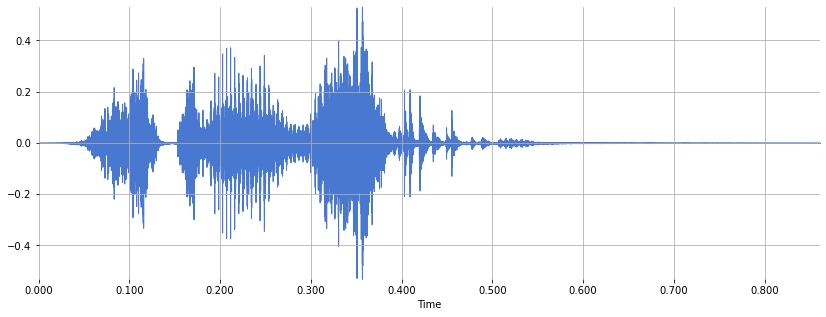

In [19]:
librosa.display.waveshow(ss, sr=sr)

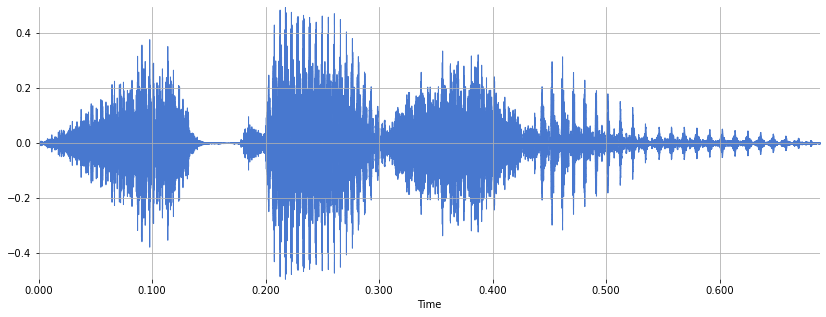

In [23]:
librosa.display.waveshow(y_t6, sr=sr)

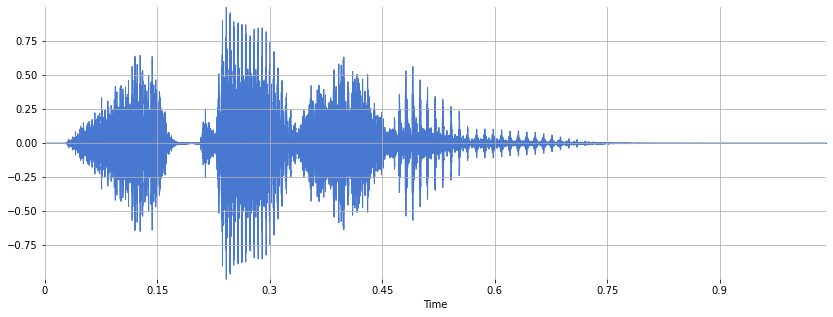

In [24]:
librosa.display.waveshow(y_t4, sr=sr)

In [25]:
librosa.get_duration(y_t4), librosa.get_duration(y_t6)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_19245/2926296551.py:1: FutureWarning: Pass y=[ 5.9976526e-07 -1.5844736e-05 -1.4710970e-05 ... -9.1558371e-07
 -2.9425333e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(y_t4), librosa.get_duration(y_t6)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_19245/2926296551.py:1: FutureWarning: Pass y=[ 0.00020895  0.00079542 -0.00023767 ... -0.00092443 -0.00067309
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(y_t4), librosa.get_duration(y_t6)


(1.0422222222222222, 0.6883446712018141)

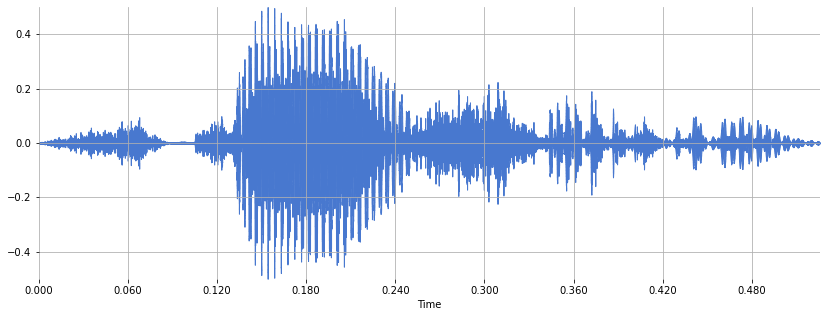

In [26]:
librosa.display.waveshow(y_t7, sr=sr)

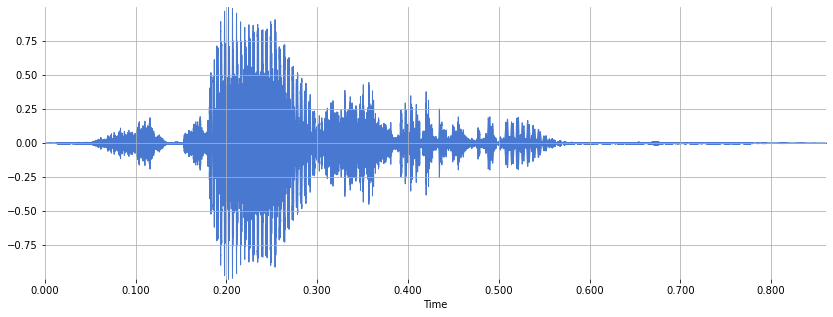

In [27]:
librosa.display.waveshow(y_t2, sr=sr)

In [28]:
librosa.get_duration(y_t7), librosa.get_duration(y_t6)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_19245/1223698012.py:1: FutureWarning: Pass y=[-0.00033591  0.00045631  0.00040196 ... -0.0014439  -0.0021134
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(y_t7), librosa.get_duration(y_t6)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_19245/1223698012.py:1: FutureWarning: Pass y=[ 0.00020895  0.00079542 -0.00023767 ... -0.00092443 -0.00067309
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(y_t7), librosa.get_duration(y_t6)


(0.52562358276644, 0.6883446712018141)

In [29]:
pre_t6 = librosa.effects.preemphasis(y_t6)
pre_t7 = librosa.effects.preemphasis(y_t7)

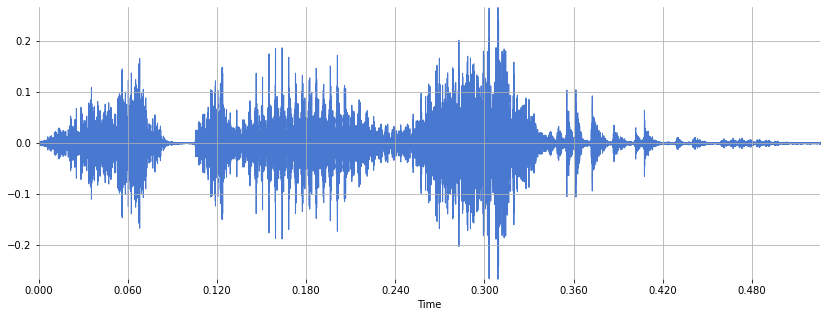

In [30]:
librosa.display.waveshow(pre_t7, sr=sr)

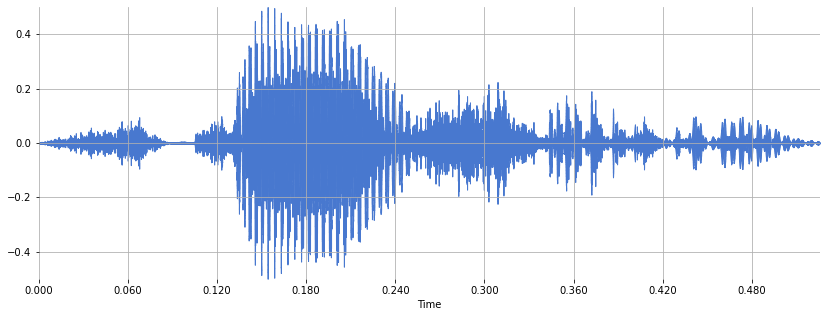

In [31]:
librosa.display.waveshow(y_t7, sr=sr)

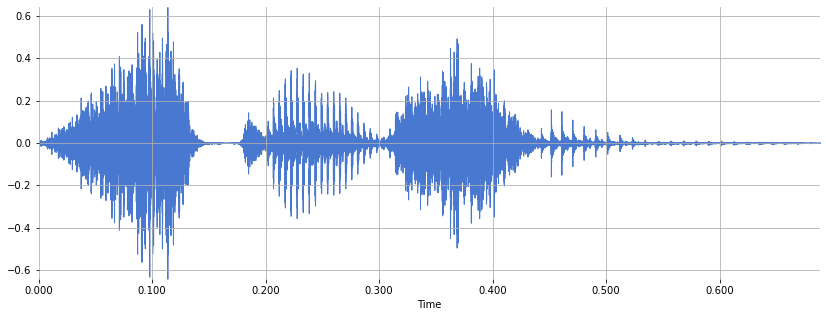

In [32]:
librosa.display.waveshow(pre_t6, sr=sr)

In [35]:
t6_mfcc = getMFCC(pre_t6, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
t7_mfcc = getMFCC(pre_t7, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_19245/2534493437.py:2: FutureWarning: Pass y=[-0.00016858  0.00059274 -0.00100922 ...  0.00050083  0.00022361
  0.0006529 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_19245/2534493437.py:2: FutureWarning: Pass y=[-1.4640535e-03  7.8214635e-04 -4.0655868e-05 ... -2.7391128e-04
 -7.1281893e-04  2.0499970e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


In [36]:
t6_mfcc_norm = getMFCCNorm(t6_mfcc)
t7_mfcc_norm = getMFCCNorm(t7_mfcc)

In [37]:
t6_ae = amplitude_envelope(pre_t6, n_fft, hop_length)
t7_ae = amplitude_envelope(pre_t7, n_fft, hop_length)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_19245/4167920513.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


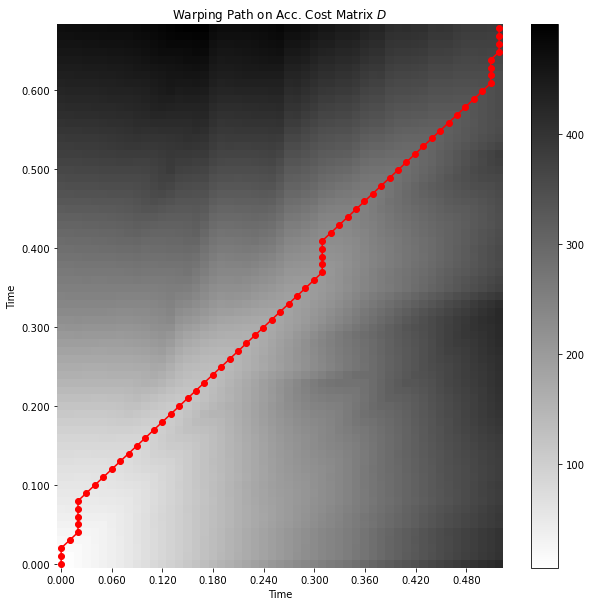

In [38]:
D, wp, wp_s = DTW(t6_mfcc_norm, t7_mfcc_norm)
plotDTW(D, wp_s)

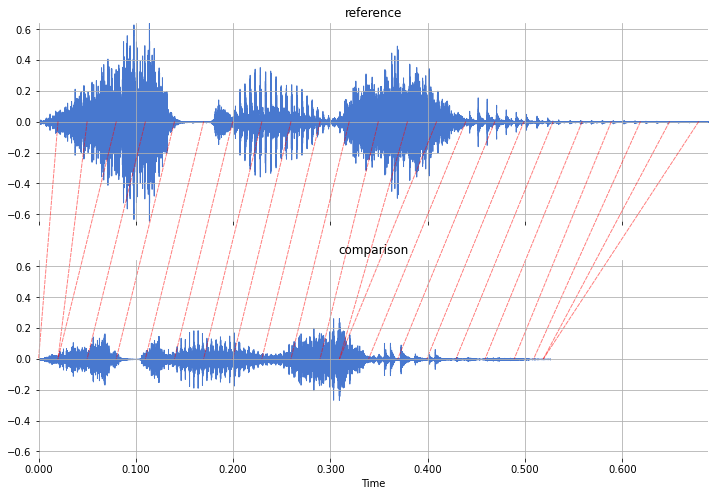

In [39]:
plotAlign(pre_t6, pre_t7)

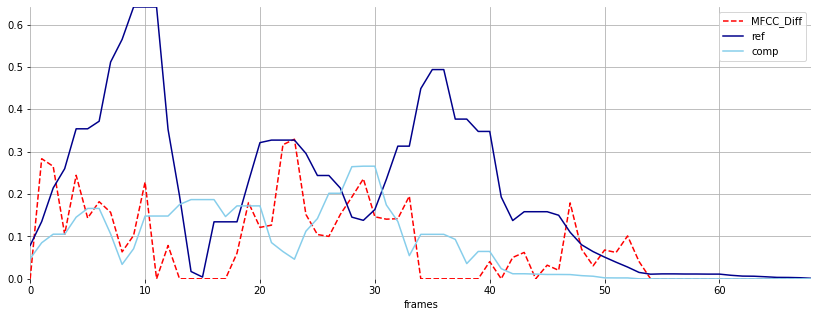

In [40]:
x, y, re_wp = getDiff(t6_mfcc_norm, t7_mfcc_norm, wp)
plotAll(x,y,t6_ae,t7_ae)

In [41]:
c = scipy.signal.correlate(pre_t6, pre_t7, mode="valid", method="fft")
peak = np.argmax(c)
offset = peak/sr
offset

0.04589569160997732

In [42]:
zeros = np.zeros(int(round(offset*sr,0)),)
tmp = np.concatenate((zeros, pre_t7), axis=0)

In [43]:
tmp.shape

(12602,)

In [44]:
tmp7_mfcc = getMFCC(tmp, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
tmp7_norm = getMFCCNorm(tmp7_mfcc)
tmp7_ae = amplitude_envelope(tmp, n_fft, hop_length)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_19245/2534493437.py:2: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00027391 -0.00071282
  0.00205   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_19245/4167920513.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


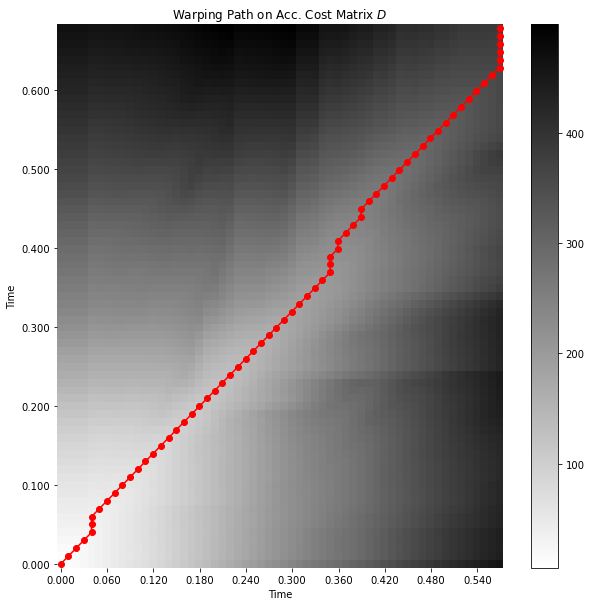

In [45]:
D, wp, wp_s = DTW(t6_mfcc_norm, tmp7_norm)
plotDTW(D, wp_s)

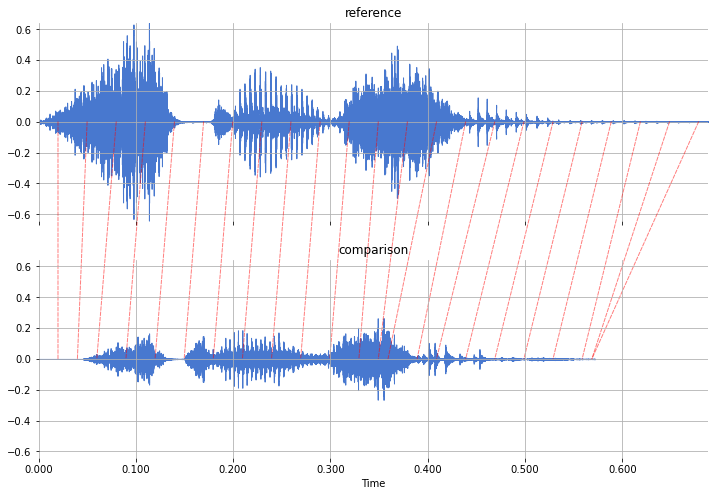

In [46]:
plotAlign(pre_t6, tmp)

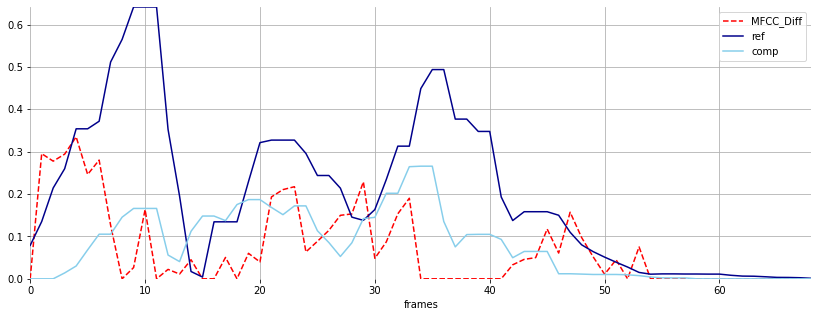

In [47]:
x, y, re_wp = getDiff(t6_mfcc_norm, tmp7_norm, wp)
plotAll(x,y,t6_ae,tmp7_ae)